In [1]:
import s3fs
import pandas as pd

from script import df_mobpro_brut, arr_marseille, arr_paris, arr_lyon

# Information d'accès au cloud MinIO (Bucket de William)
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

df_mobpro_brut=df_mobpro_brut.iloc[:50000,]
#Pour tester on ne travaille que sur les 50000 premières lignes

# Création des agrégations de base
mobpro_villes = df_mobpro_brut.groupby('COMMUNE').agg({
    'NPERR': 'sum',
    'INPSM': 'sum',
    'INPOM': 'sum',
    'INEEM': 'sum'})

# Créons d'abord un DataFrame temporaire pour chaque valeur d'ILT
for i in range(1, 8):
    # Grouper par COMMUNE et compter les occurrences où ILT == str(i)
    temp_count = df_mobpro_brut[df_mobpro_brut['ILT'] == i].groupby('COMMUNE').size()
    # Ajouter cette série au DataFrame principal
    mobpro_villes[f'ILT_{i}'] = temp_count

# Remplir les valeurs manquantes (NaN) par 0
mobpro_villes = mobpro_villes.fillna(0)

# Réinitialisation de l'index
mobpro_villes = mobpro_villes.reset_index()

# On vérifie qu'il y a autant de lignes avec un arrondissement indiqué et de lignes dont la ville de résidence est soit Paris, soit Marseille, soit Lyon (cohérence entre "ARM" et "COMMUNE")
assert len(df_mobpro_brut[df_mobpro_brut['ARM']!="ZZZZZ"])== len(df_mobpro_brut[
    (df_mobpro_brut['COMMUNE'] == '75056') | 
    (df_mobpro_brut['COMMUNE'] == '13055') | 
    (df_mobpro_brut['COMMUNE'] == '69123')])

# Liste des codes insee d'arrondissements
arr_paris = [f"751{str(i).zfill(2)}" for i in range(1, 21)]
arr_marseille = [f"132{str(i).zfill(2)}" for i in range(1, 17)]
arr_lyon = [f"6938{str(i).zfill(1)}" for i in range(1, 10)]
df_mobpro_brut.loc[
    df_mobpro_brut['COMMUNE'].isin(['75056', '13055', '69123']), 'COMMUNE'
] = df_mobpro_brut['ARM']

# Création d'une table croisée dynamique pour compter les déplacements
flux_tot = pd.crosstab(df_mobpro_brut['COMMUNE'], df_mobpro_brut['DCLT'])

# Conversion en DataFrame pour plus de clarté
flux_tot = pd.DataFrame(flux_tot)

# En option, si on veut réinitialiser l'index pour avoir COMMUNE en colonne :
# flux_tot = flux_tot.reset_index()

# Pour voir les dimensions de la matrice
print("Dimensions de la matrice :", flux_tot.shape)


# Filtrer les données pour chaque groupe de transport
df_trans_45 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([4, 5])]
df_trans_6 = df_mobpro_brut[df_mobpro_brut['TRANS'] == 6]
df_trans_123 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([1, 2, 3])]

# Créer les matrices des flux pour chaque groupe
flux_rouge = pd.crosstab(df_trans_45['COMMUNE'], df_trans_45['DCLT'])
flux_jaune = pd.crosstab(df_trans_6['COMMUNE'], df_trans_6['DCLT'])
flux_vert = pd.crosstab(df_trans_123['COMMUNE'], df_trans_123['DCLT'])

# Convertir en DataFrame pour plus de clarté
flux_rouge = pd.DataFrame(flux_rouge)
flux_jaune = pd.DataFrame(flux_jaune)
flux_vert = pd.DataFrame(flux_vert)

def flux(ville_a,ville_b):
    flux = flux_tot.loc[ville_a, ville_b]
    print(f"Nombre de personnes se déplaçant de {ville_a} vers {ville_b} : {flux}")

## Prend en arg deux codes insee en chaîne de caractère et renvoie le nombre de commute entre ces deux villes

# Top 10 des villes générant le plus de déplacements
top_villes_depart = flux_tot.sum(axis=1).sort_values(ascending=False).head(10)
top_villes_arrivee = flux_tot.sum(axis=0).sort_values(ascending=False).head(10)

transport_dict = {
    1: "Pas de transport",
    2: "Marche à pied (ou rollers, patinette)",
    3: "Vélo (y compris à assistance électrique)",
    4: "Deux-roues motorisé",
    5: "Voiture, camion, fourgonnette",
    6: "Transports en commun"
}
print(flux_tot)

/home/onyxia/work/statapp/script.py:16: DtypeWarning: Columns (1,1687,1688) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:21: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:31: DtypeWarning: Columns (1,2,3,4,14,15,16,18,22,24,27,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mobpro_brut = pd.read_csv(file)
/opt/conda/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'pyogrio_8f190d4bc4b947f09d5ae4b252d56061': 'a_com2022' (default), 'a_reg2022', 'a_dep2022'. Specify layer parameter to avoid this warning.
  result = read_func(


Dimensions de la matrice : (267, 1255)
DCLT     01001  01002  01004  01005  01006  01007  01008  01009  01010  01011  \
COMMUNE                                                                         
01001       11      0      2      0      0      0      0      0      0      0   
01002        0      4      2      0      0      2      0      0      0      0   
01004        0      0    894      0      0      7      2      0      0      0   
01005        0      0      0     31      0      0      0      0      0      0   
01006        0      0      0      0      1      0      0      0      0      0   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
01308        0      0      0      0      0      0      0      0      0      0   
01309        0      0      0      0      0      0      0      0      0      0   
01310        0      0      0      0      0      0      0      0      0      0   
01311        0      0      0      0      0      0      0      0      0

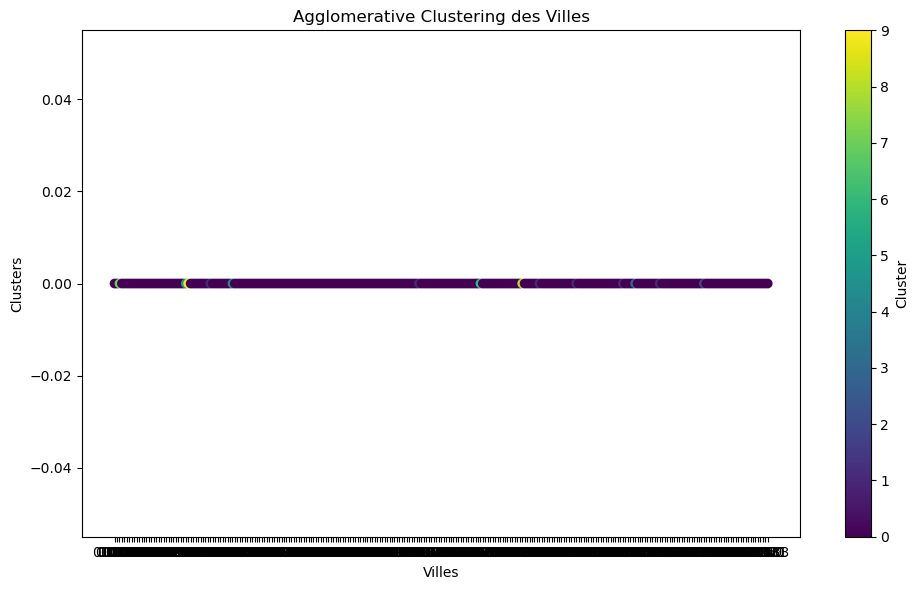

In [2]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# Normaliser les données
scaler = StandardScaler()
flux_tot_scaled = scaler.fit_transform(flux_tot)  # Normaliser flux_tot

# Application du modèle Agglomerative Clustering (avec 10 clusters)
agglomerative = AgglomerativeClustering(n_clusters=10)
labels_agglomerative = agglomerative.fit_predict(flux_tot_scaled)  # Appliquer sur flux_tot normalisé

# Ajout des labels des clusters au DataFrame original (flux_tot) pour les visualiser
flux_tot['Cluster'] = labels_agglomerative

# Affichage des résultats sous forme de DataFrame avec les villes et leurs clusters
clustered_data = flux_tot.copy()
clustered_data['Cluster'] = labels_agglomerative

# Visualisation des résultats d'Agglomerative Clustering
# Ici, je suppose que les indices des villes sont dans le DataFrame (index ou une colonne nommée 'Ville')
plt.figure(figsize=(10, 6))
plt.scatter(clustered_data.index, np.zeros_like(clustered_data.index), c=labels_agglomerative, cmap='viridis')
plt.title("Agglomerative Clustering des Villes")
plt.xlabel("Villes")
plt.ylabel("Clusters")
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()